In [1]:
import tensorflow as tf
import os
import glob
from matplotlib import pyplot as plt
%matplotlib inline


In [2]:
imgs_path = glob.glob(r'A:\cityscapes-image-pairs\cityscapes_data\train\*.jpg')

In [3]:
len(imgs_path)

2975

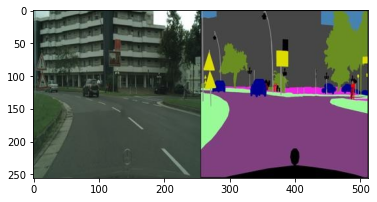

In [4]:
plt.imshow(
    tf.keras.preprocessing.image.load_img(imgs_path[0])
)

In [5]:
def read_jpg(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img,channels=3) #对图片进行解码
    return img

In [6]:
def normalize(mask,image):  #语义分割图与对应的图像
    mask = tf.cast(mask,tf.float32)/127.5 -1
    image = tf.cast(image,tf.float32)/127.5 -1
    return mask,image

In [7]:
def load_image(image_path):
    image = read_jpg(image_path) #调用加载函数加载图片
    w = tf.shape(image)[1]  #第一维是图片的高度第二维是图片的宽度
    w = w//2      #将图片一份为二
    input_mask = image[:, w:, :]
    input_image = image[:, :w, :]
    
    if tf.random.uniform(())>0.5:
        input_image = tf.image.flip_left_right(input_image)  #数据增强
        input_mask = tf.image.flip_left_right(input_mask)
        
    input_mask,input_image = normalize(input_mask,input_image)
        
    return input_mask,input_image

In [8]:
dataset = tf.data.Dataset.from_tensor_slices(imgs_path)


In [9]:
dataset = dataset.map(load_image)


In [10]:
dataset

<MapDataset shapes: ((None, None, 3), (None, None, 3)), types: (tf.float32, tf.float32)>

In [11]:
BATCH_SIZE = 64
BUFFER_SIZE = len(imgs_path)


In [12]:
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [13]:
dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)#cpu预加载

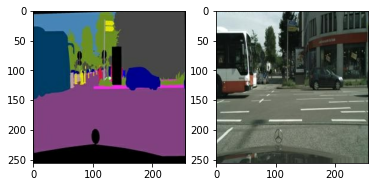

In [14]:
for musk,img in dataset.take(1):   #取一个批次的图片出来
    plt.subplot(1,2,1)
    plt.imshow(tf.keras.preprocessing.image.array_to_img(musk[5])) #因为归一化了要还原
    plt.subplot(1,2,2)
    plt.imshow(tf.keras.preprocessing.image.array_to_img(img[5]))

In [ ]:
imgs_path = glob.glob(r'A:\GAN生成对抗网络入门与实战\000、配套资料\000、配套资料 8\GAN大型数据集\2.0部分数据集\cityscapes-image-pairs\cityscapes_data\train\*.jpg')

In [16]:
dataset_tset = tf.data.Dataset.from_tensor_slices(imgs_test)

In [17]:
def load_image_test(image_path):
    image = read_jpg(image_path) #调用加载函数加载图片
    w = tf.shape(image)[1]  #第一维是图片的高度第二维是图片的宽度
    w = w//2      #将图片一份为二
    input_mask = image[:, w:, :]
    input_image = image[:, :w, :]
    
    
        
    input_mask,input_image = normalize(input_mask,input_image)
        
    return input_mask,input_image

In [18]:
dataset_test = dataset_tset.map(load_image_test)

In [19]:
dataset_test = dataset_test.batch(BATCH_SIZE)

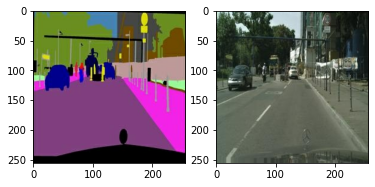

In [20]:
for musk,img in dataset_test.take(1):   #取一个批次的图片出来
    plt.subplot(1,2,1)
    plt.imshow(tf.keras.preprocessing.image.array_to_img(musk[5])) #因为归一化了要还原
    plt.subplot(1,2,2)
    plt.imshow(tf.keras.preprocessing.image.array_to_img(img[5]))

In [21]:
#创建下采样模型
def down(filters,size,apply_bn=True):
    model = tf.keras.Sequential()
    model.add(
        tf.keras.layers.Conv2D(filters,size,strides=2,padding='same',use_bias=False)
    )
    if apply_bn:
        model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
    return model

In [22]:
#创建上采样模型
def upsample(filters,size,apply_drop=False):
    model = tf.keras.Sequential()
    model.add(
        tf.keras.layers.Conv2DTranspose(filters,size,strides=2,padding='same',use_bias=False)
    )
    
    model.add(tf.keras.layers.BatchNormalization())
    if apply_drop:
        model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.ReLU())
    return model

In [23]:
def Generator():
    inputs = tf.keras.layers.Input(shape=(256,256,3))
    
    down_stack = [
        down(64, 4, apply_bn=False),     #128*128*64
        down(128, 4),                    #64*64*128
        down(256, 4),                    #32*32*256
        down(512, 4),                    #16*16*512
        down(512, 4),                    #8*8*512
        down(512, 4),                    #4*4*512
        down(512, 4),                    #2*2*512
        down(512, 4),                    #1*1*512
    ]
    
    up_stack = [
        upsample(512, 4, apply_drop=True),                    #2*2*512
        upsample(512, 4, apply_drop=True),                    #4*4*512
        upsample(512, 4, apply_drop=True),                    #8*8*512
        upsample(512, 4),                                     #16*16*512
        upsample(256, 4),                                         #32*32*256
        upsample(128, 4),                                         #64*64*128
        upsample(64, 4),                                         #128*128*64
    ]
    
    x = inputs
    skips = []
    
    for d in down_stack:
        x = d(x)
        skips.append(x)   #把中间值放到空列表中将中间值保留下来
        
    skips = reversed(skips[ :-1])  #去掉最后一个值并反转
    
    for u, skip in zip(up_stack,skips):
        x = u(x)                                 #先上采用再结合
        x = tf.keras.layers.Concatenate()([x,skip])  # x为128*128*128
        
    x = tf.keras.layers.Conv2DTranspose(3,4,strides=2,padding='same',activation='tanh')(x)
    return tf.keras.Model(inputs=inputs,outputs=x)

In [24]:
generator = Generator()
generator.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 128, 128, 64) 3072        input_1[0][0]                    
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 64, 64, 128)  131584      sequential[0][0]                 
__________________________________________________________________________________________________
sequential_2 (Sequential)       (None, 32, 32, 256)  525312      sequential_1[0][0]               
______________________________________________________________________________________________

In [25]:
def Disc():
    inp = tf.keras.layers.Input(shape=(256,256,3))
    tar = tf.keras.layers.Input(shape=(256,256,3))
    
    x = tf.keras.layers.concatenate([inp,tar])  #256*256*6
    
    x = down(64,4,apply_bn=False)(x)              #128*128*64
    x = down(128,4)(x)                            #64*64*128
    x = down(256,4)(x)                            #32*32*256
    
    x = tf.keras.layers.Conv2D(512,4,strides=1,padding='same',use_bias=False)(x)   #(32,32,512)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU()(x)
    
    x = tf.keras.layers.Conv2D(1,3,strides=1)(x)        #30*30*1
    
    return tf.keras.Model(inputs=[inp,tar],outputs=x)

In [26]:
discriminator = Disc()
discriminator.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
concatenate_7 (Concatenate)     (None, 256, 256, 6)  0           input_2[0][0]                    
                                                                 input_3[0][0]                    
__________________________________________________________________________________________________
sequential_15 (Sequential)      (None, 128, 128, 64) 6144        concatenate_7[0][0]        

In [27]:
loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [28]:
LAMBDA = 10

In [29]:
def generator_loss(d_gen_output, gen_output, target):
    gen_loss = loss_fn(tf.ones_like(d_gen_output),d_gen_output)
    
    l1_loss = tf.reduce_mean(tf.abs(target - gen_output))
    
    return gen_loss + LAMBDA*l1_loss


In [30]:
def discriminator_loss(d_real_output,d_gen_output):
    real_loss = loss_fn(tf.ones_like(d_real_output),d_real_output)
    g_loss = loss_fn(tf.zeros_like(d_gen_output),d_gen_output)
    return real_loss + g_loss

In [31]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4,beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4,beta_1=0.5)

In [32]:
def generate_image(model, test_input, tar):
    prediction = model(test_input,training=True)
    plt.figure(figsize=(15,15))
    
    display_list = [test_input[0], tar[0],prediction[0]]
    title = ['Input Image', 'Ground Truth', 'Predicted Image']
    
    for i in range(3):
        plt.subplot(1,3,i+1)
        plt.title(title[i])
        #还原归一化到【0，1】之间
        plt.imshow(display_list[i]*0.5 + 0.5)
        plt.axis('off')
     
    plt.show()
    

In [33]:
EPOCHS = 150

In [34]:
@tf.function
def train_step(input_image, target, epoch):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        gen_output = generator(input_image,training=True)
        
        disc_real_output = discriminator([input_image,target],training=True)
        disc_generator_output = discriminator([input_image,gen_output],training=True)
        
        gen_total_loss = generator_loss(disc_generator_output,gen_output,target)
        disc_loss = discriminator_loss(disc_real_output,disc_generator_output)
        
        generator_gradients = gen_tape.gradient(gen_total_loss,generator.trainable_variables)  
        discriminator_gradients = disc_tape.gradient(disc_loss,discriminator.trainable_variables)
        
        generator_optimizer.apply_gradients(zip(generator_gradients,generator.trainable_variables))
        discriminator_optimizer.apply_gradients(zip(discriminator_gradients,discriminator.trainable_variables))
        

In [35]:
def fit(train_ds, epochs, test_ds):
    for epoch in range(epochs+1):
        if epoch%10 == 0:
            for example_input, example_target in test_ds.take(1):
                generate_image(generator,example_input,example_target)
        print("Epoch:",epoch)
        
        for n, (input_image,target) in train_ds.enumerate():
            print('.',end='')
            train_step(input_image,target,epoch)
        print()

In [36]:
fit(dataset, EPOCHS, dataset_test)

UnknownError: Failed to get convolution algorithm. This is probably because cuDNN failed to initialize, so try looking to see if a warning log message was printed above. [Op:Conv2D]

In [1]:
!nvidia-smi

Thu Dec 03 19:09:34 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 452.06       Driver Version: 452.06       CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce RTX 2060   WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   48C    P8    10W /  N/A |    164MiB /  6144MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                                  |
|  GPU  